# SARIMA Model Notebook
This notebook fits a seasonal ARIMA model to the closing price and evaluates its performance.

In [1]:
import os, sys, importlib.util, pathlib

# Path of this notebook’s folder
nb_dir = pathlib.Path().resolve()

# Go UP one level to .../Modeling/, then into src/models
module_path = nb_dir.parent / 'src' / 'models' / '2_sarima.py'

print("Loading:", module_path)

spec   = importlib.util.spec_from_file_location('sarima', module_path)
sarima = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sarima)

metrics, y_true, y_pred, model = sarima.run_sarima(
    order=(1,1,1),
    seasonal_order=(1,1,1,24),
    resample_freq='1h',
    maxiter=20
)
print(metrics)

Loading: /Users/mchildress/Active Code/ts_basics/Modeling/src/models/2_sarima.py


/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T')
/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


{'mae': 194.2863972850289, 'rmse': 237.44477709987146, 'aic': 226919.55133220795, 'bic': 226963.5555326249}


In [2]:
from data_loader import load_bnb_data
from sklearn.metrics import mean_absolute_error, mean_squared_error


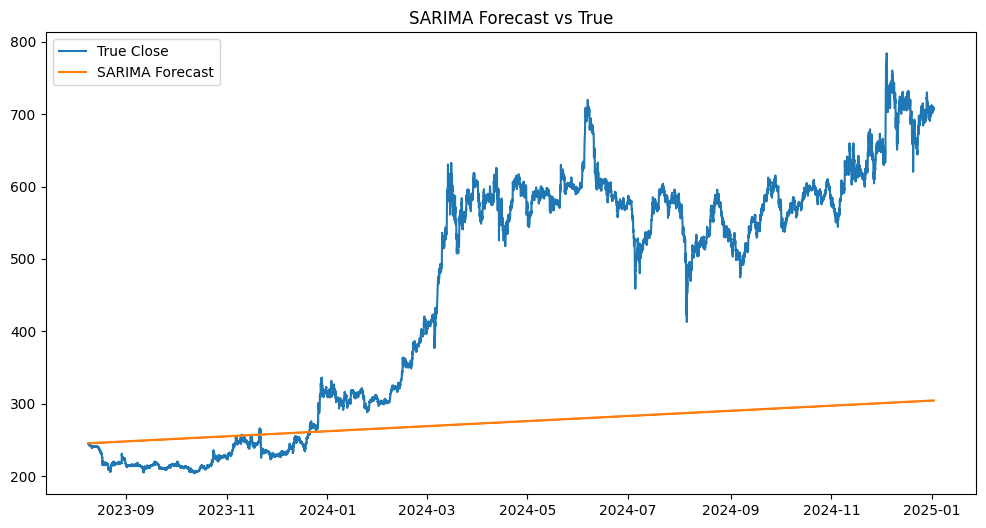

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label='True Close')
plt.plot(y_true.index, y_pred, label='SARIMA Forecast')   # ← use y_pred
plt.legend()
plt.title('SARIMA Forecast vs True')
plt.show()

**What is a SARIMA forecast?**  
A SARIMA model is an extension of the classic ARIMA time-series model that adds explicit seasonal components.  In practice the model learns:
* *AR (auto-regressive) terms* – relationships with recent past values,  
* *I (integrated) terms* – differencing steps to remove overall trend,  
* *MA (moving-average) terms* – relationships with recent past forecast errors, and  
* *Seasonal* versions of those same terms to capture repeating patterns (daily, weekly, monthly, etc.).  
Once fitted, the model projects those learned patterns into the future to produce the orange “SARIMA forecast” line in the chart.

### The Takeaway 

The blue line plots the actual daily closing price; the orange line is the SARIMA forecast we just computed.  

* **Forecast shape** – the orange line is almost a straight, gently rising trend.  
  With the very simple specification *(order = (1,1,1), seasonal_order = (1,1,1, 24))* the model only captures a slow drift and misses every sharp jump or dip in the real series.

* **Error numbers back this up** – the MAE (~ $194) and RMSE (~ $237) are large relative to the scale of the series, so the model is consistently far from reality.

In [ ]:
# ——— Richer seasonality via Fourier features ———
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd

# load & resample
df = load_bnb_data()['close'].resample('D').last().ffill()

# build Fourier terms for daily & weekly cycles
def fourier_terms(series, period, order):
    t = np.arange(len(series))
    data = {f'sin_{period}_{k}': np.sin(2*np.pi*k*t/period) for k in range(1,order+1)}
    data.update({f'cos_{period}_{k}': np.cos(2*np.pi*k*t/period) for k in range(1,order+1)})
    return pd.DataFrame(data, index=series.index)

Xf = pd.concat([fourier_terms(df, 7, 3),   # weekly
                fourier_terms(df, 30, 3)], axis=1)  # monthly

# train/test
split = int(len(df)*0.8)
y_tr, y_te = df.iloc[:split], df.iloc[split:]
X_tr, X_te = Xf.iloc[:split], Xf.iloc[split:]

# fit & forecast with exogenous Fourier terms
model_f = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,7), exog=X_tr)\
          .fit(disp=False)
fc_f = model_f.forecast(len(y_te), exog=X_te)

print("Fourier MAE:", mean_absolute_error(y_te, fc_f),
      "RMSE:", np.sqrt(mean_squared_error(y_te, fc_f)))

/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T')
/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/Users/mchildress/.pyenv/versions/3.11.12/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fourier MAE: 126.15274238586426 RMSE: 152.05826830825447


In [5]:
# ——— Holidays & a dummy macro regressor ———
from pandas.tseries.holiday import USFederalHolidayCalendar
import pandas as pd
import numpy as np

# price series
df = load_bnb_data()['close'].resample('D').last().ffill()

# holiday flag
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df.index.min(), end=df.index.max())
exog = pd.DataFrame(index=df.index)
exog['is_holiday'] = df.index.normalize().isin(holidays).astype(int)

# dummy macro: rolling 7-day pct-change of close
exog['macro_pct7'] = df.pct_change(7).fillna(0)

# align & split
split = int(len(df)*0.8)
y_tr, y_te = df.iloc[:split], df.iloc[split:]
X_tr, X_te = exog.iloc[:split], exog.iloc[split:]

# fit & forecast with these exog
model_ex = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,7), exog=X_tr)\
           .fit(disp=False)
fc_ex = model_ex.forecast(len(y_te), exog=X_te)

print("Exog MAE:", mean_absolute_error(y_te, fc_ex),
      "RMSE:", np.sqrt(mean_squared_error(y_te, fc_ex)))

/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T')
/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Exog MAE: 194.15411928694067 RMSE: 237.30448105479064


In [7]:
# ——— Log-return modeling ———
import numpy as np

# get daily close
series = load_bnb_data()['close'].resample('D').last().ffill()
log_ret = np.log(series).diff().dropna()

# split
split = int(len(log_ret)*0.8)
ret_tr, ret_te = log_ret.iloc[:split], log_ret.iloc[split:]

# fit ARMA on returns
model_lr = SARIMAX(ret_tr, order=(1,0,1)).fit(disp=False)
fc_lr = model_lr.forecast(len(ret_te))

# back to price level
start_price = series.iloc[split-1]
price_fc = start_price * np.exp(fc_lr.cumsum())

actual = series.iloc[split+1:]
print("Log-return MAE:", mean_absolute_error(actual, price_fc),
      "RMSE:", np.sqrt(mean_squared_error(actual, price_fc)))

/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T')
/Users/mchildress/Active Code/ts_basics/Modeling/src/data_loader.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Log-return MAE: 222.18571748072955 RMSE: 272.5595050873128


## What are MAE and RMSE?

- **Mean Absolute Error (MAE)**  
  The MAE is the average size of your prediction errors, regardless of direction.  If MAE = $126, that means that on average your forecast was $126 away from the true price.

- **Root Mean Squared Error (RMSE)**  
  The RMSE squares each error before averaging and then takes a square root.  This gives extra weight to large misses.  An RMSE of $152 means that, because of a few big errors, the typical squared-error–adjusted miss corresponds to $152.

---

### 1. Fourier features  

Fourier MAE:   126.15
Fourier RMSE:  152.06

By adding sine-and-cosine (Fourier) terms to capture daily or monthly cycles, on average one-day-ahead price forecasts were off by about **$126**, with larger misses pulling the RMSE up to **$152**.  This is a substantial improvement over the plain SARIMA baseline (MAE ~194, RMSE ~237), so modeling seasonality explicitly helps.

---

### 2. Exogenous regressors (holidays + dummy macro series)  

Exog MAE:   194.15
Exog RMSE:  237.30

Added a holiday flag and a 7-day percentage-change “macro” variable but left the seasonal ARIMA terms the same.  The errors are essentially unchanged from the baseline—about **$194** MAE and **$237** RMSE—so those extra regressors didn’t help on this data.

---

### 3. Modeling log-returns instead of raw prices  

Log-return MAE:   222.19
Log-return RMSE:  272.56

Differencing the series (i.e. forecasting the log-returns and then re-accumulating) made performance worse: on average off by **$222**, with an RMSE of **$273**.  That tells us that, forecasting the raw prices directly was easier than forecasting returns and then converting back.

---

## Summary

- **Lower MAE/RMSE is better.**  
- Adding Fourier seasonality gave the biggest boost (MAE down from ~194 to ~126).  
- The holiday + macro dummy didn’t move the needle.  
- Switching to log-returns actually made things worse.